/var/folders/sd/x6b24fj17sg_pd8tj67xfp4r0000gn/T/ipykernel_35839/1385474474.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


Selected features for 7-day prediction: ['sp500_close', 'treasury_3m', 'Open_x', 'High_x', 'unemployment_rate']
R² score for 7-day prediction: 0.9895509230261709
Mean Absolute Error (MAE): 5.623880743218825
Mean Squared Error (MSE): 55.717265633427644
Root Mean Squared Error (RMSE): 7.464399884346205


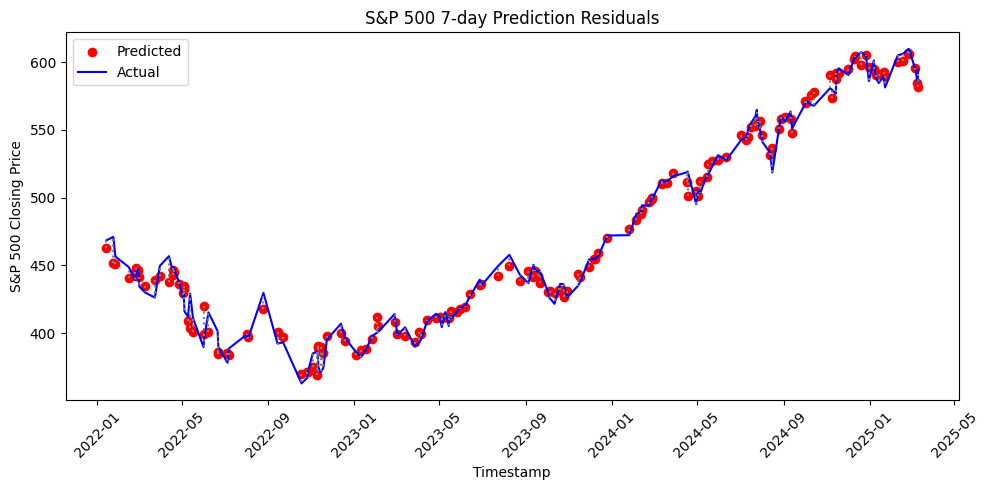

Selected features for 30-day prediction: ['Open_x', 'treasury_3m', 'High_x', 'unemployment_rate', 'Low_x', 'Close_x']
R² score for 30-day prediction: 0.9810987829888648
Mean Absolute Error (MAE): 7.172885180175691
Mean Squared Error (MSE): 91.44364552532564
Root Mean Squared Error (RMSE): 9.562617085574724


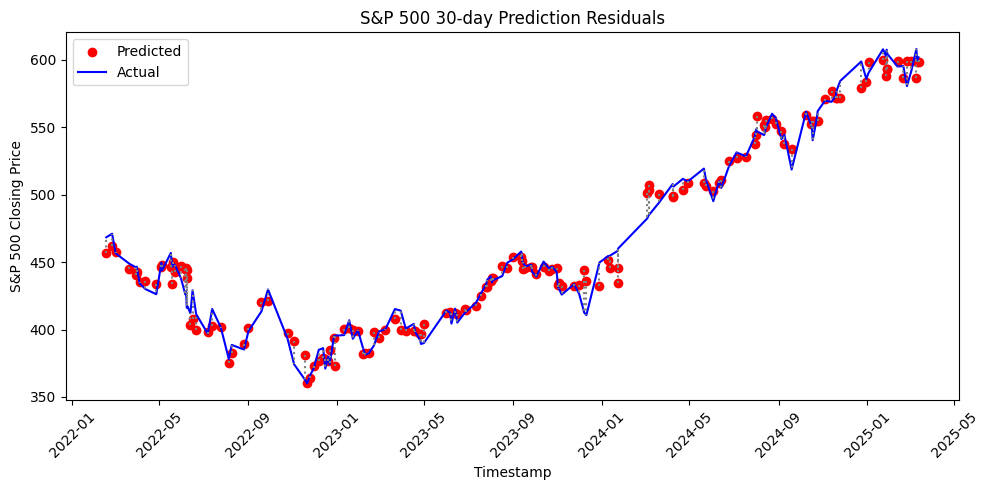

Selected features for 180-day prediction: ['sp500_close', 'treasury_3m', 'Open_x', 'High_x', 'unemployment_rate', 'ETF', 'Low_x']
R² score for 180-day prediction: 0.9690792540562676
Mean Absolute Error (MAE): 6.024845331780528
Mean Squared Error (MSE): 64.46738797781278
Root Mean Squared Error (RMSE): 8.029158609581254


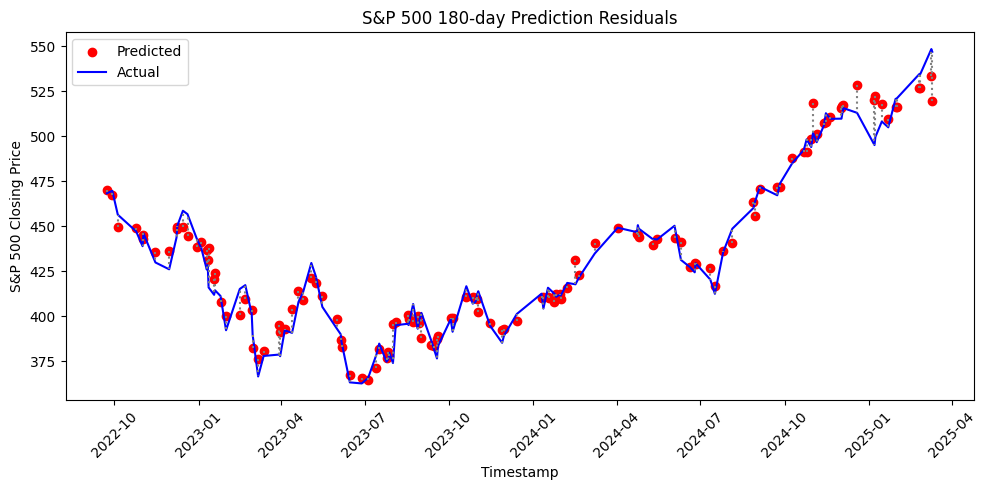

Final results: {7: {'R²': 0.9895509230261709, 'MAE': 5.623880743218825, 'MSE': 55.717265633427644, 'RMSE': 7.464399884346205}, 30: {'R²': 0.9810987829888648, 'MAE': 7.172885180175691, 'MSE': 91.44364552532564, 'RMSE': 9.562617085574724}, 180: {'R²': 0.9690792540562676, 'MAE': 6.024845331780528, 'MSE': 64.46738797781278, 'RMSE': 8.029158609581254}}


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# Define file path
data_path = "data"
file_names = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "google_trends": "google_trends.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv",
    "copper": "copper.csv",
    "oil": "oil.csv",
    "unemployment": "unemployment.csv"
}

# Load datasets
data = {}
for key, file in file_names.items():
    file_path = os.path.join(data_path, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["timestamp"])
        df.replace({'.': np.nan}, inplace=True)  # Replace non-numeric values with NaN
        for col in df.columns:
            if col != "timestamp":
                df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
        data[key] = df
    else:
        print(f"File not found: {file_path}")

# Standardize column names
if "sp500" in data:
    data["sp500"] = data["sp500"].rename(columns={"Close": "sp500_close"})
if "copper" in data:
    data["copper"] = data["copper"].rename(columns={"price": "copper_price"})
if "oil" in data:
    data["oil"] = data["oil"].rename(columns={"Close": "oil_close"})
if "unemployment" in data:
    data["unemployment"] = data["unemployment"].rename(columns={"Unemployment": "unemployment_rate"})

# Merge datasets on timestamp
sp500 = data["sp500"]
all_data = sp500[["timestamp", "sp500_close"]]

for key, df in data.items():
    if key != "sp500" and df is not None:
        all_data = all_data.merge(df, on="timestamp", how="left")

# Convert timestamp back to datetime for sorting
all_data["timestamp"] = pd.to_datetime(all_data["timestamp"])
all_data.sort_values("timestamp", inplace=True)

# Fill missing values
all_data.fillna(method='ffill', inplace=True)

# Define prediction intervals
prediction_intervals = [7, 30, 180]
results = {}

for interval in prediction_intervals:
    # Create a separate target column for each interval
    all_data[f"sp500_target_{interval}"] = all_data["sp500_close"].shift(interval)
    
    # Drop rows with NaN target values
    model_data = all_data.dropna(subset=[f"sp500_target_{interval}"])
    
    # Define features and target, excluding previous target columns
    feature_columns = [col for col in model_data.columns if col not in ["timestamp"] + [f"sp500_target_{i}" for i in prediction_intervals]]
    X = model_data[feature_columns]
    y = model_data[f"sp500_target_{interval}"]
    timestamps = model_data["timestamp"]
    
    # Split data
    X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
        X, y, timestamps, test_size=0.2, random_state=42)
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    
    # Feature importance selection
    importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = importance.importances_mean.argsort()[::-1]
    selected_features = [feature_columns[i] for i in sorted_idx if importance.importances_mean[i] > 0.01]
    
    print(f"Selected features for {interval}-day prediction:", selected_features)
    
    # Retrain with selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    model.fit(X_train_selected, y_train)
    
    # Predict values
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[interval] = {"R²": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}
    
    print(f"R² score for {interval}-day prediction: {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    # Sort values by timestamp for plotting
    sorted_indices = np.argsort(timestamps_test.values)
    timestamps_sorted = timestamps_test.values[sorted_indices]
    y_test_sorted = y_test.values[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    
    # Plot residuals
    plt.figure(figsize=(10, 5))
    plt.scatter(timestamps_sorted, y_pred_sorted, label="Predicted", color='red', marker='o')
    plt.plot(timestamps_sorted, y_test_sorted, label="Actual", color='blue')
    for i in range(len(timestamps_sorted)):
        plt.plot([timestamps_sorted[i], timestamps_sorted[i]], [y_pred_sorted[i], y_test_sorted[i]], color='gray', linestyle='dotted')
    plt.title(f"S&P 500 {interval}-day Prediction Residuals")
    plt.xlabel("Timestamp")
    plt.ylabel("S&P 500 Closing Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Output results
print("Final results:", results)
